# Importing libraries

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Data preprocessing

In [97]:
df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
df.reset_index(inplace=True)
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low
df = df.dropna()

# Store all predictor variables in a variable X
X = df[['Open-Close', 'High-Low']]
X.head()




[*********************100%***********************]  1 of 1 completed


Price,Open-Close,High-Low
Ticker,,
0,-0.017454,0.063798
1,0.006621,0.070419
2,0.102619,0.134820
3,0.035210,0.088777
4,-0.050557,0.088475


# Target variables


In the case of SVM-s, we have to rewrite the problem in the form of a classification exercise. Luckily with stocks, we can do this easily by doing binary classification based on the relative change of prices

In [98]:
y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
y


array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], shape=(3522, 1))

Price,Date,Close,High,Low,Open,Volume,Open-Close,High-Low
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,
count,3522,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03,3522.000000,3522.000000
mean,2016-12-30 22:57:51.209540096,57.574681,58.154507,56.940304,57.532586,2.422834e+08,-0.042095,1.214203
min,2010-01-04 00:00:00,5.779476,5.898344,5.725307,5.789105,2.404830e+07,-9.998000,0.037918
25%,2013-07-03 12:00:00,16.948896,17.103423,16.785681,16.966752,9.266760e+07,-0.251848,0.266313
50%,2016-12-29 12:00:00,29.039499,29.255419,28.786085,29.039403,1.526602e+08,-0.016809,0.508747
75%,2020-06-30 18:00:00,88.776251,90.046476,88.015218,88.781727,3.284715e+08,0.204419,1.684831
max,2023-12-29 00:00:00,196.927689,198.428672,195.824294,196.838229,1.880998e+09,6.967110,12.491012
std,NaN,55.520111,56.088908,54.889501,55.463714,2.204578e+08,1.172791,1.500850


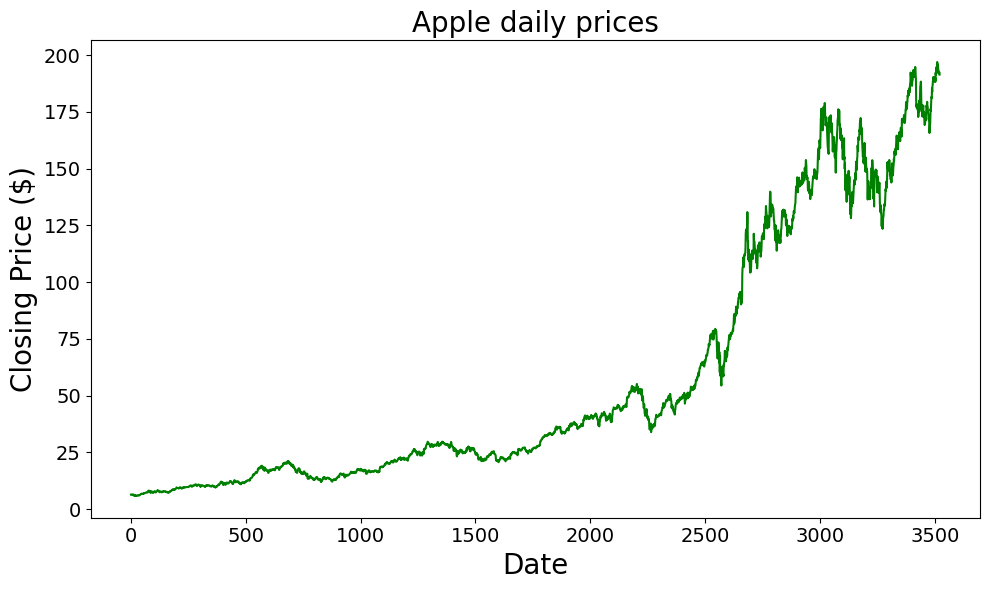

In [99]:
plt.figure(figsize=(10,6))
plt.plot(
  df.index,
  df['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices", fontsize=20)
plt.tight_layout()
df.describe()

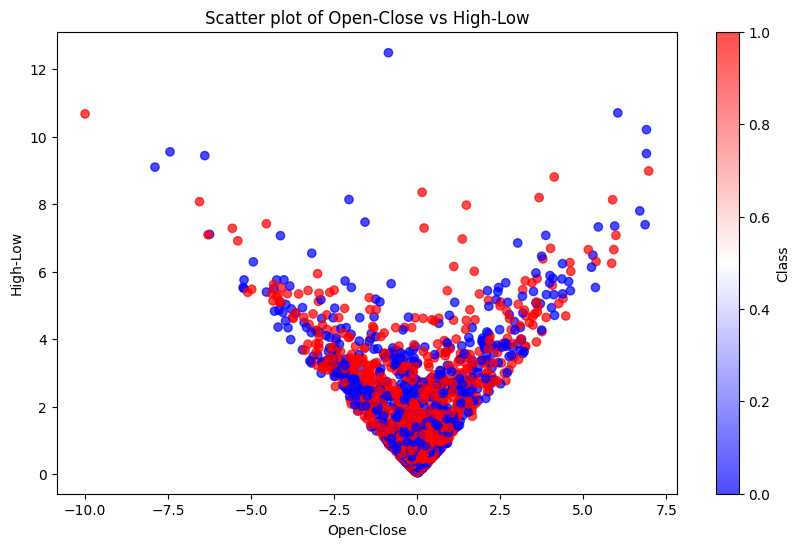

In [100]:
plt.figure(figsize=(10,6))
plt.scatter(X['Open-Close'], X['High-Low'], c=y, cmap='bwr', alpha=0.7)
plt.xlabel('Open-Close')
plt.ylabel('High-Low')
plt.title('Scatter plot of Open-Close vs High-Low')
plt.colorbar(label='Class')
plt.show()

Doesn't look linearly separable at all, what is more, they seem to all be in the same bunch. However, maybe the right kernel function can do the trick, provided that the two classes are separable in higher dimensions.

# Splitting the data into sets

In [101]:
split_percentage = 0.8
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
y_train = y[:split]

# Test data set
X_test = X[split:]
y_test = y[split:]


# Fitting a model

In [102]:
# Support vector classifier
cls = SVC().fit(X_train, y_train.ravel()) # Uses rbf kernel by default

In [103]:
df['Predicted_Signal'] = cls.predict(X)
df['Predicted_Signal'].value_counts()

Predicted_Signal
1    3012
0     510
Name: count, dtype: int64

In [ ]:
df['Return'] = df.Close.pct_change()
df['Strategy_Return'] = df.Return * df.Predicted_Signal.shift(1)

# Calculate Cumulutive returns
df['Cum_Ret'] = df['Return'].cumsum()
# Strategy Cumulative returns 
df['Cum_Strategy'] = df['Strategy_Return'].cumsum()
df

Price,Date,Close,High,Low,Open,Volume,Open-Close,High-Low,Predicted_Signal,Return,Strategy_Return,Cum_Ret
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
0,2010-01-04,6.440331,6.455076,6.391278,6.422876,493729600,-0.017454,0.063798,1,NaN,NaN,NaN
1,2010-01-05,6.451466,6.487879,6.417459,6.458086,601904800,0.006621,0.070419,1,0.001729,0.001729,0.001729
2,2010-01-06,6.348847,6.477046,6.342227,6.451467,552160000,0.102619,0.134820,1,-0.015906,-0.015906,-0.014177
3,2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200,0.035210,0.088777,1,-0.001849,-0.001849,-0.016026
4,2010-01-08,6.379242,6.379844,6.291369,6.328685,447610800,-0.050557,0.088475,1,0.006649,0.006649,-0.009378
...,...,...,...,...,...,...,...,...,...,...,...,...
3517,2023-12-22,192.444595,194.243791,191.818350,194.015153,37122800,1.570557,2.425440,1,-0.005547,-0.005547,3.954703
3518,2023-12-26,191.897873,192.732856,191.679185,192.454528,28919300,0.556655,1.053671,1,-0.002841,-0.002841,3.951862
3519,2023-12-27,191.997269,192.345186,189.949565,191.341219,48087700,-0.656050,2.395621,0,0.000518,0.000518,3.952380


# Plot strategy returns vs original returns

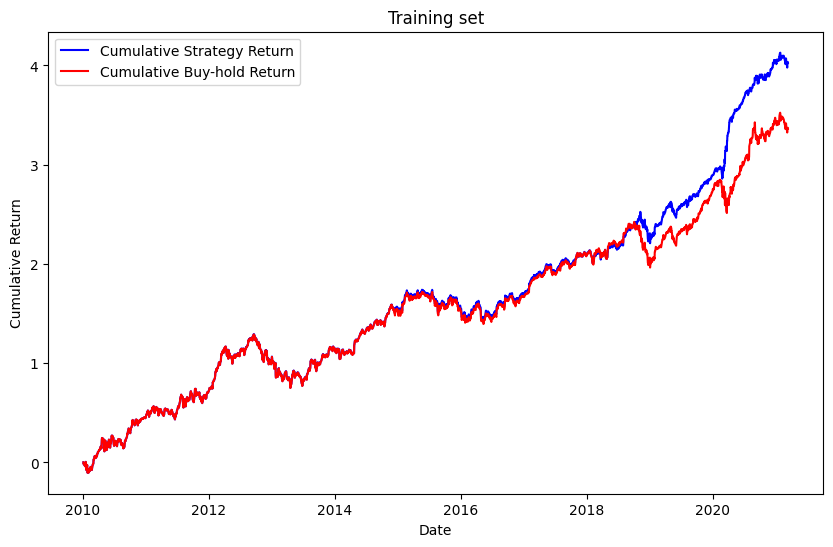

In [109]:
train_plot = df[:split]
test_plot = df[split:]

plt.figure(figsize=(10,6))
plt.plot(train_plot['Date'], train_plot['Cum_Strategy'], label='Cumulative Strategy Return', color='blue')
plt.plot(train_plot['Date'], train_plot['Cum_Ret'], label='Cumulative Buy-hold Return', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Training set')
plt.legend()
plt.show()

# Recalculate cumulative returns for test set

In [111]:
test_plot['Cum_Ret'] = test_plot['Return'].cumsum()
# Strategy Cumulative returns 
test_plot['Cum_Strategy'] = test_plot['Strategy_Return'].cumsum()

test_plot.head()

/tmp/ipykernel_3617/2641283438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_plot['Cum_Ret'] = test_plot['Return'].cumsum()
/tmp/ipykernel_3617/2641283438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_plot['Cum_Strategy'] = test_plot['Strategy_Return'].cumsum()


Price,Date,Close,High,Low,Open,Volume,Open-Close,High-Low,Predicted_Signal,Return,Strategy_Return,Cum_Ret,Cum_Strategy
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
2817,2021-03-15,121.292061,121.301845,117.799742,118.768206,92403800,-2.523855,3.502103,0,0.024457,0.000000,0.024457,0.000000
2818,2021-03-16,122.837669,124.451768,122.006166,122.964838,115227900,0.127169,2.445601,0,0.012743,0.000000,0.037200,0.000000
2819,2021-03-17,122.045311,123.121374,119.677963,121.350761,111932600,-0.694550,3.443411,1,-0.006450,-0.000000,0.030749,0.000000
2820,2021-03-18,117.907349,120.499688,117.701919,120.206213,121229700,2.298864,2.797769,1,-0.033905,-0.033905,-0.003156,-0.033905
2821,2021-03-19,117.379089,118.787758,117.075837,117.291051,185549500,-0.088038,1.711921,1,-0.004480,-0.004480,-0.007636,-0.038385


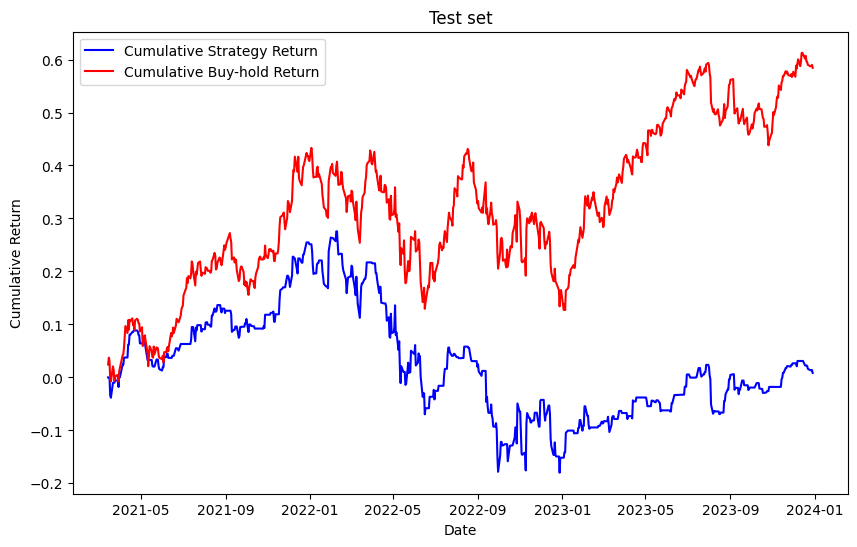

Buy-Hold returns: 0.5844065734327257
Strategy returns: 0.00847839411090534


In [113]:
plt.figure(figsize=(10,6))
plt.plot(test_plot['Date'], test_plot['Cum_Strategy'], label='Cumulative Strategy Return', color='blue')
plt.plot(test_plot['Date'], test_plot['Cum_Ret'], label='Cumulative Buy-hold Return', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Test set')
plt.legend()
plt.show()

print(f"Buy-Hold returns: {test_plot['Cum_Ret'].iloc[-1]}")
print(f"Strategy returns: {test_plot['Cum_Strategy'].iloc[-1]}")

## Conclusion
Looks like our strategy netted a 0.8% increase in our portfolio in the period of several years. In other words, it is hardly better than randomly guessing. Definitely a better outcome than with linear regression, but that is still not saying much

Of course the method could be imporved in a myriad of ways, such as using differernt predictive parameters, choosing a different kernel, or applying scaling to the paramters (in this case scaling was not needed though, since we used relative measurements. However, if we were to include e.g.: the volume of trades in our model, scaling would definitely be needed!).